# Scrapping Atlantic Books Details

**Looking for the `Browse By Category` Element**

In [ ]:
# from selenium import webdriver
# from selenium.webdriver.common.action_chains import ActionChains
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium.webdriver.support import expected_conditions as EC

# # Set up the webdriver
# driver = webdriver.Chrome()

# # Navigate to the webpage
# driver.get("https://atlanticbooks.com/")

# # Wait for and find the 'Browse By Category' element
# browse_by_category = WebDriverWait(driver, 20).until(
#     EC.element_to_be_clickable((By.XPATH, "//*[@id='site-header-nav']/nav/ul/li[3]/details/summary"))
# )

# # Create an ActionChains object
# actions = ActionChains(driver)

# # Move to the 'Browse By Category' element and click to open it
# actions.move_to_element(browse_by_category).click().perform()

# # Wait for and find the 'Fiction' element within the opened dropdown menu
# fiction_element = WebDriverWait(driver, 20).until(
#     EC.element_to_be_clickable((By.LINK_TEXT, "Fiction"))
# )

# # Move to the 'Fiction' element and click on it
# actions.move_to_element(fiction_element).click().perform()

# # # Close the browser
# # driver.quit()


# Code fetching `fiction`, `non-fiction` and `Classics` elements under "Browse By Category" element

In [16]:
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import random
import time
import pandas as pd
from datetime import datetime

# Initialize list to store book data
Books_data = []

# Set up the webdriver
driver = webdriver.Chrome()
driver.maximize_window()

# Function to scrape book data from a specific category
def scrape_category(category_name):
    try:
        # Wait for and find the 'Browse By Category' element
        browse_by_category = WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.XPATH, "//*[@id='site-header-nav']/nav/ul/li[3]/details/summary"))
        )

        # Create an ActionChains object
        actions = ActionChains(driver)

        # Move to the 'Browse By Category' element and click to open it
        actions.move_to_element(browse_by_category).click().perform()

        # Wait for and find the specific category element within the opened dropdown menu
        category_element = WebDriverWait(driver, 20).until(
            EC.element_to_be_clickable((By.LINK_TEXT, category_name))
        )

        # Move to the category element and click on it
        actions.move_to_element(category_element).click().perform()

        # Pagination logic
        page = 1
        while True:
            print(f"Scraping page {page} of {category_name}...")

            # Allow some random delay to mimic human behavior
            time.sleep(random.uniform(3, 7))

            # Locate all book containers on the current page
            book_elements = driver.find_elements(By.CLASS_NAME, "productitem__container")
            if not book_elements:
                print(f"No books found on page {page}. Exiting...")
                break

            for book in book_elements:
                try:
                    # Locate the product link element
                    link_element = book.find_element(By.CLASS_NAME, "productitem--image-link")
                    # Extract the href attribute (the URL)
                    book_link = link_element.get_attribute("href")
                    print(book_link)

                    # Navigate to the book detail page
                    driver.get(book_link)
                    WebDriverWait(driver, 10).until(
                        EC.presence_of_element_located((By.CLASS_NAME, "product-details"))
                    )

                    # Extract book details
                    book_details = driver.find_element(By.CLASS_NAME, "product-details")
                    title = book_details.find_element(By.TAG_NAME, "h2").text
                    author = driver.find_element(By.CLASS_NAME, "custom-liquid").text
                    price = driver.find_element(By.CLASS_NAME, "price__current.price__current--on-sale").find_element(By.CLASS_NAME, "money").text

                    # Extract additional details
                    additional_data = {}
                    li_tags = driver.find_elements(By.CSS_SELECTOR, "div.tab-panel li")
                    for li in li_tags:
                        text = li.text
                        if "Publication Date:" in text:
                            date_string = text.replace("Publication Date: ", "").strip()
                            try:
                                date_object = datetime.strptime(date_string, "%B %d, %Y")
                                additional_data["Publication Date"] = date_object.strftime("%Y-%m-%d")
                            except ValueError:
                                additional_data["Publication Date"] = "N/A"
                        elif ":" in text:
                            key, value = text.split(":", 1)
                            additional_data[key.strip()] = value.strip()

                    # Combine all data into a dictionary
                    book_data = {
                        "Title": title,
                        "Author": author,
                        "Price": price,
                        "Link": book_link,
                        "Category": category_name
                    }
                    book_data.update(additional_data)

                    # Append the data to the list
                    Books_data.append(book_data)

                except Exception as e:
                    print(f"Error extracting book details: {e}")

                # Return to the search results page
                driver.back()
                WebDriverWait(driver, 10).until(
                    EC.presence_of_all_elements_located((By.CLASS_NAME, "productitem__container"))
                )

            # Locate the 'Next' button and extract its URL
            try:
                next_button = driver.find_element(By.CSS_SELECTOR, "li.pagination--next a.pagination--item")
                next_page_url = next_button.get_attribute("href")
                if not next_page_url:
                    print("No more pages to scrape. Exiting...")
                    break

                # Navigate to the next page
                print(f"Navigating to the next page: {next_page_url}")
                driver.get(next_page_url)
                WebDriverWait(driver, 10).until(
                    EC.presence_of_all_elements_located((By.CLASS_NAME, "productitem__container"))
                )
                page += 1

            except Exception as e:
                print(f"No 'Next' button found for {category_name}. Exiting pagination loop...")
                break

    except Exception as e:
        print(f"An error occurred during scraping {category_name}: {e}")

# Navigate to the webpage
driver.get("https://atlanticbooks.com/")

# Scrape both Fiction and Non-Fiction categories
for category in ["Fiction", "Non-Fiction", "Classics"]:
    scrape_category(category)

# Close the browser
driver.quit()

# Convert the data into a DataFrame
df = pd.DataFrame(Books_data)

# Print the DataFrame
print(df)

# Save the DataFrame to a CSV file
df.to_csv("Books_data.csv", index=False)


Scraping page 1 of Fiction...
https://atlanticbooks.com/collections/fiction/products/volpone
https://atlanticbooks.com/collections/fiction/products/twelfth-night
https://atlanticbooks.com/collections/fiction/products/the-rudyard-kipling-collection
https://atlanticbooks.com/collections/fiction/products/the-old-man-and-the-sea
https://atlanticbooks.com/collections/fiction/products/pride-and-prejudice
https://atlanticbooks.com/collections/fiction/products/oliver-twist
https://atlanticbooks.com/collections/fiction/products/henry-iv-part-one
https://atlanticbooks.com/collections/fiction/products/candide
https://atlanticbooks.com/collections/fiction/products/the-odyssey-9788124806401
https://atlanticbooks.com/collections/fiction/products/siddhartha-9788124806128
https://atlanticbooks.com/collections/fiction/products/ulysses-by-james-joyce-9788124805732
https://atlanticbooks.com/collections/fiction/products/treasure-island
https://atlanticbooks.com/collections/fiction/products/to-the-lighthou

# Working on the scrapped data

In [482]:
# Getting the csv file using pandas
df = pd.read_csv("Books_data.csv")
df.head(5)

,Title,Author,Price,Link,Category,ISBN13,Binding,Subject,Publisher,Publisher Imprint,Publication Date,Pages,Original Price,Language,Edition,Item Weight
0,Volpone,by Ben Jonson,Rs. 158.00,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124803004,Hardcover,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2020-06-15,132.0,INR 225.00,English,NaN,180 grams
1,Twelfth Night,by William Shakespeare,Rs. 94.00,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124800591,Paperback,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2023-03-13,108.0,INR 125.00,English,NaN,820 grams
2,The Rudyard Kipling Collection,by Rudyard Kipling,Rs. 637.00,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124804995,Paperback,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2024-06-15,1014.0,INR 849.00,English,NaN,1118 grams
3,The Old Man and the Sea,by Ernest Hemingway,Rs. 175.00,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124805329,Hardcover,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2023-08-11,98.0,INR 250.00,English,NaN,190 grams
4,Pride And Prejudice,by Jane Austen,Rs. 222.00,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124800195,Paperback,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2024-04-02,340.0,INR 295.00,English,NaN,230 grams


In [483]:
# Checking the shape of the csv
df.shape

(419, 16)

In [484]:
# Getting the sum of duplicates in the data
df.duplicated().sum()

90

In [485]:
# Dropping the duplicates
df.drop_duplicates(inplace=True)

print("Sum of duplicates after keeping the first occurence of each duplicate row:", df.duplicated().sum())

Sum of duplicates after keeping the first occurence of each duplicate row: 0


In [486]:
# Checking the info of the dataframe:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 329 entries, 0 to 388
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Title              329 non-null    object 
 1   Author             329 non-null    object 
 2   Price              329 non-null    object 
 3   Link               329 non-null    object 
 4   Category           329 non-null    object 
 5   ISBN13             329 non-null    int64  
 6   Binding            328 non-null    object 
 7   Subject            328 non-null    object 
 8   Publisher          329 non-null    object 
 9   Publisher Imprint  324 non-null    object 
 10  Publication Date   322 non-null    object 
 11  Pages              328 non-null    float64
 12  Original Price     328 non-null    object 
 13  Language           328 non-null    object 
 14  Edition            2 non-null      float64
 15  Item Weight        329 non-null    object 
dtypes: float64(2), int64(1), object

In [487]:
# Checking null values
df.isnull().sum()

Title                  0
Author                 0
Price                  0
Link                   0
Category               0
ISBN13                 0
Binding                1
Subject                1
Publisher              0
Publisher Imprint      5
Publication Date       7
Pages                  1
Original Price         1
Language               1
Edition              327
Item Weight            0
dtype: int64

In [488]:
# Dropping the Edition Column, since Edition Column has only 2 non-null values
df.drop('Edition', axis = 1, inplace = True)
df.columns

Index(['Title', 'Author', 'Price', 'Link', 'Category', 'ISBN13', 'Binding',
       'Subject', 'Publisher', 'Publisher Imprint', 'Publication Date',
       'Pages', 'Original Price', 'Language', 'Item Weight'],
      dtype='object')

In [489]:
# Replacing null values with "Data Missing" in specified columns
df[['Subject', 'Publisher Imprint', 'Language', 'Binding']] = df[['Subject', 'Publisher Imprint', 'Language', 'Binding']].fillna("Data Missing")

In [490]:
# Filling null value with -1 in page column as I am goint to convert its data type into int dtype 
df['Pages'] = df['Pages'].fillna(-1)

In [491]:
# Filling null value with -1 in page column as I am goint to convert its data type into int dtype 
df['Original Price'] = df['Original Price'].fillna(-1)

In [492]:
# Converting 'Publication Date' to datetime format
df['Publication Date'] = pd.to_datetime(df['Publication Date']) 

# Verify the data type
print(df['Publication Date'].dtype)

datetime64[ns]


In [493]:
# Drop rows with null values in the 'Publication Date' column
df = df.dropna(subset=['Publication Date'])

In [494]:
df.isnull().sum()

Title                0
Author               0
Price                0
Link                 0
Category             0
ISBN13               0
Binding              0
Subject              0
Publisher            0
Publisher Imprint    0
Publication Date     0
Pages                0
Original Price       0
Language             0
Item Weight          0
dtype: int64

In [495]:
# Converting the price column into integer type.
# Remove "Rs. ", "," and convert it to float type

import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')

df['Price'] = df['Price'].str.replace('Rs. ', '').str.replace(',', '').astype(float)

In [496]:
# Removing the noise value from the authors column
df['Author'] = df['Author'].str.replace('by ', '')

In [497]:
# Removing the noise values from Item Weight column and converting it into int type
df['Item Weight'] = df['Item Weight'].str.replace(' grams', '').astype(int)

In [498]:
# Removing the noise value from the Original Price column
df['Original Price'] = df['Original Price'].str.replace('INR ', '').astype(float)

In [499]:
# Convertig the column names into lower case so that it is easy to code
df.columns = df.columns.str.lower()
df.columns = df.columns.str.replace(' ', '_')
df.columns

Index(['title', 'author', 'price', 'link', 'category', 'isbn13', 'binding',
       'subject', 'publisher', 'publisher_imprint', 'publication_date',
       'pages', 'original_price', 'language', 'item_weight'],
      dtype='object')

In [500]:
# Filling null value with -1 in page column as I am goint to convert its data type into int dtype 
df['original_price'] = df['original_price'].fillna(-1)

In [501]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, 0 to 388
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              322 non-null    object        
 1   author             322 non-null    object        
 2   price              322 non-null    float64       
 3   link               322 non-null    object        
 4   category           322 non-null    object        
 5   isbn13             322 non-null    int64         
 6   binding            322 non-null    object        
 7   subject            322 non-null    object        
 8   publisher          322 non-null    object        
 9   publisher_imprint  322 non-null    object        
 10  publication_date   322 non-null    datetime64[ns]
 11  pages              322 non-null    float64       
 12  original_price     322 non-null    float64       
 13  language           322 non-null    object        
 14  item_weight    

**Counting the number of outliers present in the numeric colums**

In [503]:
# Select numeric columns
numeric_columns = df.select_dtypes(include=['float64', 'int32']).columns

# Function to calculate outliers using IQR
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((series < lower_bound) | (series > upper_bound)).sum()

# Count outliers for each numeric column
outlier_counts = {col: count_outliers(df[col]) for col in numeric_columns}

print("\nCount of outliers in each numeric column:")
print(outlier_counts)


Count of outliers in each numeric column:
{'price': 32, 'pages': 27, 'original_price': 30, 'item_weight': 42}


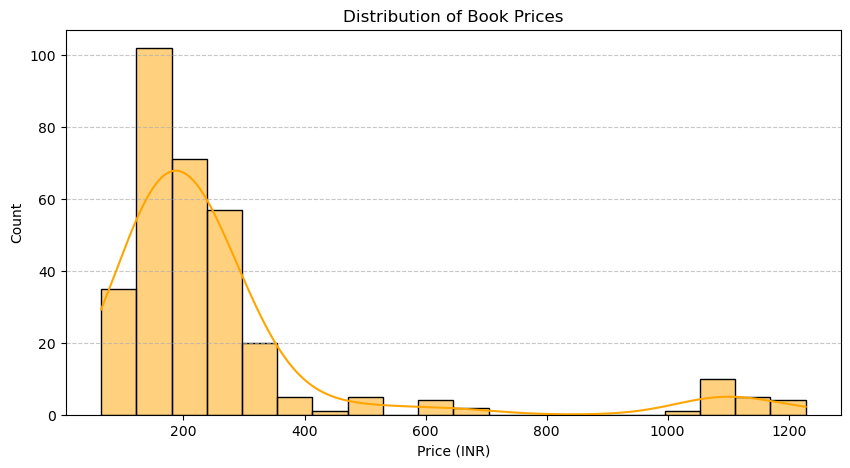

In [615]:
import matplotlib.pyplot as plt
import seaborn as sns

# Showing the Disrtibution of book prices.

plt.figure(figsize=(10, 5))
sns.histplot(df["price"], bins=20, color="orange", kde=True, line_kws={"color": "red"})
plt.title("Distribution of Book Prices")
plt.xlabel("Price (INR)")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**The analysis of book prices tells:**
- Most prices are concentrated between 100-400 INR, with a peak around 200 INR.
- A long tail indicates some books are priced significantly higher (up to 1200 INR).
- Few books are priced above 800 INR.

`These insights can help in understanding the pricing trends and making informed decisions about setting competitive prices for books.`

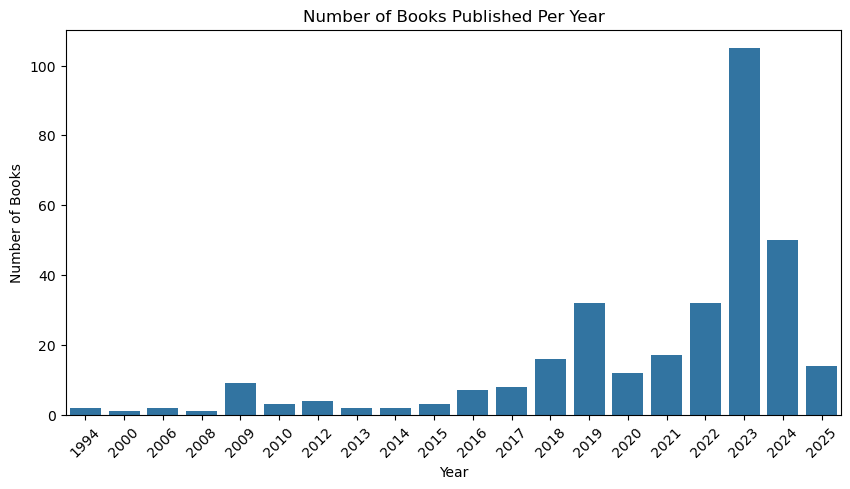

In [506]:
# Using line plot to show the count of books published over time

# Extracting the year from the Publication Date column
df["Year"] = df["publication_date"].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(x=df["Year"], order=sorted(df["Year"].unique()))
plt.xticks(rotation=45)
plt.title("Number of Books Published Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Books")
plt.show()

**The analysis of book publications over the years tells that:**
- Year-over-year fluctuations in the number of books published
- A peak in publications in 2023 may be due to E-publishing and self-publishing platforms could have influenced the number of books published or Economic booms might lead to increased publishing activity.
- An overall increasing trend in publications over the past few years

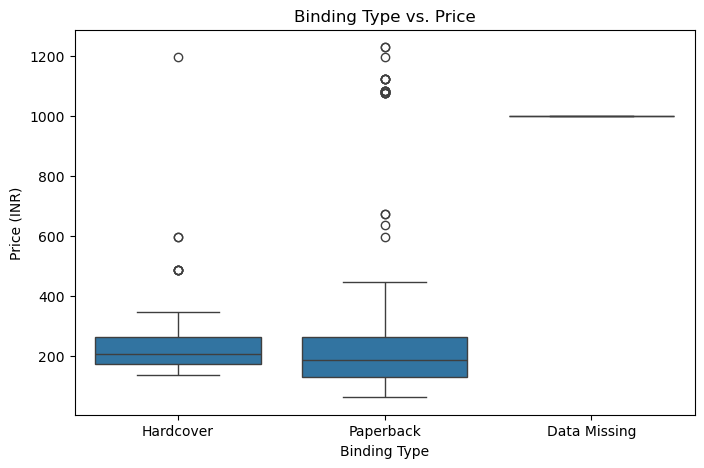

In [508]:
# Checking the price of the Bindings using (sns.boxplot)

plt.figure(figsize=(8, 5))
sns.boxplot(x=df["binding"], y=df["price"])
plt.title("Binding Type vs. Price")
plt.xlabel("Binding Type")
plt.ylabel("Price (INR)")
plt.show()


The box plot provides a clear visual comparison of the price distributions for different book binding types. It highlights that Hardcover books generally have higher prices than Paperback books, while the price distribution for books with missing binding information is more varied. In essence, it suggests that the prices of books where the binding type is unknown show a greater degree of spread or dispersion compared to books with known binding types (Hardcover and Paperback).

In [510]:
df.head()

,title,author,price,link,category,isbn13,binding,subject,publisher,publisher_imprint,publication_date,pages,original_price,language,item_weight,Year
0,Volpone,Ben Jonson,158.0,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124803004,Hardcover,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2020-06-15,132.0,225.0,English,180,2020
1,Twelfth Night,William Shakespeare,94.0,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124800591,Paperback,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2023-03-13,108.0,125.0,English,820,2023
2,The Rudyard Kipling Collection,Rudyard Kipling,637.0,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124804995,Paperback,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2024-06-15,1014.0,849.0,English,1118,2024
3,The Old Man and the Sea,Ernest Hemingway,175.0,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124805329,Hardcover,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2023-08-11,98.0,250.0,English,190,2023
4,Pride And Prejudice,Jane Austen,222.0,https://atlanticbooks.com/collections/fiction/...,Fiction,9788124800195,Paperback,English Literature,Atlantic Publishers & Distributors (P) Ltd,Peacock Books,2024-04-02,340.0,295.0,English,230,2024


In [511]:
# Converting the Year column in datetime format
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Verify the data type
print(df['Year'].dtype)

datetime64[ns]


In [512]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 322 entries, 0 to 388
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              322 non-null    object        
 1   author             322 non-null    object        
 2   price              322 non-null    float64       
 3   link               322 non-null    object        
 4   category           322 non-null    object        
 5   isbn13             322 non-null    int64         
 6   binding            322 non-null    object        
 7   subject            322 non-null    object        
 8   publisher          322 non-null    object        
 9   publisher_imprint  322 non-null    object        
 10  publication_date   322 non-null    datetime64[ns]
 11  pages              322 non-null    float64       
 12  original_price     322 non-null    float64       
 13  language           322 non-null    object        
 14  item_weight    

In [513]:
df['original_price'].isnull().sum()

0

In [514]:
df.duplicated().sum()

0

In [515]:
counts = df.groupby('title').size()
print(counts)

title
24 The Challenging New Number Puzzle       1
A Doll's House                             1
A Farewell to Arms                         2
A Portrait Of The Artist As A Young Man    3
A Tale Of A Tub And Other Works            2
                                          ..
Volpone                                    2
Women In Love                              2
Wuthering Heights                          2
Yes, I Am Bihari                           1
Yoga For Stress Management                 1
Length: 154, dtype: int64


In [516]:
# df.to_csv("Cleaned_books_data.csv")  # Save to a CSV file

# The Data is ready, now Connecting with MySQL Workbench

In [518]:
!pip install pymysql

In [519]:
import pymysql
connection = pymysql.connect(
    host='127.0.0.1',
    user='root',
    password='your_password',
    database='atlantic_books'
)
print("Connection successful!")

Connection successful!


In [520]:
pip install SQLAlchemy

In [521]:
pip install mysql-connector-python

Note: you may need to restart the kernel to use updated packages.


In [522]:
# Now loading the data in MySQL

import sqlalchemy as sal
from sqlalchemy.pool import NullPool


# Replace the credentials with your own
username = 'root'
password = 'your_password'        # Replace it with your SQL credentials
host = '127.0.0.1'
database = 'atlantic_books'


# Create engine with MySQL Connector/Python
engine = sal.create_engine(f'mysql+pymysql://{username}:{password}@{host}/{database}',
                           poolclass=NullPool)
# from sqlalchemy import create_engine
# engine = create_engine("mysql+pymysql://user:pw@host/db", pool_pre_ping=True)

# Establish connection
conn = engine.connect()

# Load data into MySQL using replace option
df.to_sql(name='books_data', con=engine, schema='atlantic_books', if_exists='replace', index=False)

322

In [523]:
# The pandas will create a table highest possible data types, so we will create the table ourselves.
# What we will do is that we replace, if_exists='replace' with if_exists='append'
# after dropping the existing table books_data and create new table 'books_data' in sql.

# Execute SQL query using pandas to drop the table
from sqlalchemy import text

with engine.connect() as conn:
    conn.execute(text("DROP TABLE IF EXISTS books_data;"))
    print("Table dropped successfully")



Table dropped successfully


In [524]:
# The pandas will create a table highest possible data types, so we will create the table ourselves.


query = """
CREATE TABLE books_data (
    title VARCHAR(255),
    author VARCHAR(255),
    price DECIMAL(10,2),
    link TEXT,
    category VARCHAR(255),
    isbn13 BIGINT,
    binding VARCHAR(100),
    subject VARCHAR(255),
    publisher VARCHAR(255),
    publisher_imprint VARCHAR(255),
    publication_date DATE,
    pages INT,
    original_price DECIMAL(10,2),
    language VARCHAR(100),
    item_weight INT,
    year DATE
);
"""


In [525]:
# Now appending the data in df_orders table: 

df.to_sql(name='books_data', con=engine, schema='atlantic_books', if_exists='append', index=False)

322

In [595]:
from tabulate import tabulate

# Count of books published/year

query = """
SELECT YEAR(publication_date) AS year, COUNT(*) AS total_books
FROM books_data
GROUP BY YEAR(publication_date)  -- ✅ Explicitly grouping by YEAR(publication_date)
ORDER BY year DESC;

"""
result_df = pd.read_sql_query(query, engine)

# Print result in table format
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+--------+---------------+
|    |   year |   total_books |
|----+--------+---------------|
|  0 |   2025 |            14 |
|  1 |   2024 |            50 |
|  2 |   2023 |           105 |
|  3 |   2022 |            32 |
|  4 |   2021 |            17 |
|  5 |   2020 |            12 |
|  6 |   2019 |            32 |
|  7 |   2018 |            16 |
|  8 |   2017 |             8 |
|  9 |   2016 |             7 |
| 10 |   2015 |             3 |
| 11 |   2014 |             2 |
| 12 |   2013 |             2 |
| 13 |   2012 |             4 |
| 14 |   2010 |             3 |
| 15 |   2009 |             9 |
| 16 |   2008 |             1 |
| 17 |   2006 |             2 |
| 18 |   2000 |             1 |
| 19 |   1994 |             2 |
+----+--------+---------------+


In [603]:
# Finding the most expensive books

query = """
SELECT title, author, price 
FROM books_data 
ORDER BY price DESC 
LIMIT 5;

"""
result_df = pd.read_sql_query(query, engine)

# Print result in table format
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+---------------------------------------------------------+----------------------+---------+
|    | title                                                   | author               |   price |
|----+---------------------------------------------------------+----------------------+---------|
|  0 | The Thomas Hardy Collection                             | Thomas Hardy         |    1228 |
|  1 | The Thomas Hardy Collection                             | Thomas Hardy         |    1228 |
|  2 | The Best of Children's Classics (MULTI VOL SET-8 Vols.) | Multiple Authors     |    1197 |
|  3 | Capitalism, Socialism and Democracy                     | Joseph A. Schumpeter |    1196 |
|  4 | The Jane Austen Collection                              | Jane Austen          |    1122 |
+----+---------------------------------------------------------+----------------------+---------+


In [597]:
from tabulate import tabulate

# Ranking Books Within Each Category by Price

query = """
    SELECT title, category, price,
    dense_rank() OVER (PARTITION BY category ORDER BY price DESC) AS category_price_rank
    FROM books_data;
"""
result_df = pd.read_sql_query(query, engine)

# Print result in table format
print(tabulate(result_df, headers='keys', tablefmt='fancy_grid'))

╒═════╤══════════════════════════════════════════════════════════════════════╤═════════════╤═════════╤═══════════════════════╕
│     │ title                                                                │ category    │   price │   category_price_rank │
╞═════╪══════════════════════════════════════════════════════════════════════╪═════════════╪═════════╪═══════════════════════╡
│   0 │ The Thomas Hardy Collection                                          │ Classics    │    1228 │                     1 │
├─────┼──────────────────────────────────────────────────────────────────────┼─────────────┼─────────┼───────────────────────┤
│   1 │ The Best of Children's Classics (MULTI VOL SET-8 Vols.)              │ Classics    │    1197 │                     2 │
├─────┼──────────────────────────────────────────────────────────────────────┼─────────────┼─────────┼───────────────────────┤
│   2 │ The Jane Austen Collection                                           │ Classics    │    1122 │         

In [599]:
# Identifying books that have Prices above the average

query = """
    SELECT title, author, price,
    AVG(price) OVER () AS avg_price,
    CASE 
	    WHEN price > AVG(price) OVER () THEN 'Above Average'
	    ELSE 'Below Average'
	    END AS price_category
FROM books_data;
"""
result_df = pd.read_sql_query(query, engine)

# # Adjust column width
# pd.set_option('display.max_colwidth', 100)

# Print result in table format
print(tabulate(result_df, headers='keys', tablefmt='fancy_grid'))

╒═════╤══════════════════════════════════════════════════════════════════════╤════════════════════════════════════════════════════╤═════════╤═════════════╤══════════════════╕
│     │ title                                                                │ author                                             │   price │   avg_price │ price_category   │
╞═════╪══════════════════════════════════════════════════════════════════════╪════════════════════════════════════════════════════╪═════════╪═════════════╪══════════════════╡
│   0 │ Volpone                                                              │ Ben Jonson                                         │     158 │     266.217 │ Below Average    │
├─────┼──────────────────────────────────────────────────────────────────────┼────────────────────────────────────────────────────┼─────────┼─────────────┼──────────────────┤
│   1 │ Twelfth Night                                                        │ William Shakespeare                           

In [601]:
from IPython.display import display
from tabulate import tabulate

pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', None)

# Correct column order
result_df = result_df[['title', 'author', 'price', 'avg_price', 'price_category']]

# Display DataFrame in a readable format
display(result_df) 


,title,author,price,avg_price,price_category
0,Volpone,Ben Jonson,158.0,266.217391,Below Average
1,Twelfth Night,William Shakespeare,94.0,266.217391,Below Average
2,The Rudyard Kipling Collection,Rudyard Kipling,637.0,266.217391,Above Average
3,The Old Man and the Sea,Ernest Hemingway,175.0,266.217391,Below Average
4,Pride And Prejudice,Jane Austen,222.0,266.217391,Below Average
...,...,...,...,...,...
317,Adam Bede,George Eliot,297.0,266.217391,Above Average
318,A Tale Of Two Cities,Charles Dickens,277.0,266.217391,Above Average
319,A Tale Of A Tub And Other Works,Jonathan Swift,147.0,266.217391,Below Average
320,A Portrait Of The Artist As A Young Man,James Joyce,175.0,266.217391,Below Average


In [605]:
#  Identify the most common book category

query = """
SELECT category, COUNT(*) AS category_count
FROM books_data
GROUP BY category
ORDER BY category_count DESC
LIMIT 1;

"""
result_df = pd.read_sql_query(query, engine)

# Print result in table format
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+------------+------------------+
|    | category   |   category_count |
|----+------------+------------------|
|  0 | Classics   |              126 |
+----+------------+------------------+


In [609]:
#  Finding books that had a price drop (Original price vs. current price)

query = """
SELECT title, original_price, price, 
ROUND(((original_price - price) / original_price) * 100, 2) AS discount_percentage
FROM books_data
WHERE original_price > price
ORDER BY discount_percentage DESC;

"""
result_df = pd.read_sql_query(query, engine)

# Print result in table format
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+-----+----------------------------------------------------------------------+------------------+---------+-----------------------+
|     | title                                                                |   original_price |   price |   discount_percentage |
|-----+----------------------------------------------------------------------+------------------+---------+-----------------------|
|   0 | Middlemarch                                                          |              495 |     245 |                 50.51 |
|   1 | Middlemarch                                                          |              495 |     245 |                 50.51 |
|   2 | The Old Man and the Sea                                              |              250 |     175 |                 30    |
|   3 | The Jungle Books                                                     |              250 |     175 |                 30    |
|   4 | Sons And Lovers                                                     

In [607]:
#  Finding the average page count by each subject

query = """
SELECT subject, ROUND(AVG(pages), 2) AS avg_pages
FROM books_data
GROUP BY subject
ORDER BY avg_pages DESC;


"""
result_df = pd.read_sql_query(query, engine)

# Print result in table format
print(tabulate(result_df, headers='keys', tablefmt='psql'))

+----+-----------------------------------+-------------+
|    | subject                           |   avg_pages |
|----+-----------------------------------+-------------|
|  0 | Children Books                    |      670    |
|  1 | Economics                         |      504    |
|  2 | Sociology and Anthropology        |      415    |
|  3 | English Literature                |      405.51 |
|  4 | History                           |      385    |
|  5 | Data Missing                      |      288    |
|  6 | Business Management               |      240    |
|  7 | General Books                     |      236.86 |
|  8 | Health, Physical Fitness and Yoga |      226    |
|  9 | Creative Writing, Fiction         |      200    |
| 10 | Religion and Philosophy           |      152.8  |
| 11 | Politics and Current Affairs      |       -1    |
+----+-----------------------------------+-------------+
